In [1]:
import numpy as np
import sklearn as sk
from sklearn.metrics.pairwise import cosine_similarity as cos_sim_sk
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import torch
from torch.nn.functional import cosine_similarity as cossim_pt
from typing import Sequence, Dict, Tuple, List, Optional, Union

In [2]:
from huggingface_hub import notebook_login

notebook_login()

In [3]:
# Import GPT-2 Model and Tokenizer
from transformers import GPT2Model, GPT2Tokenizer
gpt2 = GPT2Model.from_pretrained('gpt2')
tokenizer_gpt2 = GPT2Tokenizer.from_pretrained('gpt2')
embeddings_gpt2 = gpt2.wte.weight.detach().numpy()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [4]:
# position embeddings
pe = gpt2.wpe.weight.detach().numpy()
pe.shape

(1024, 768)

# Visualize the position embeddings

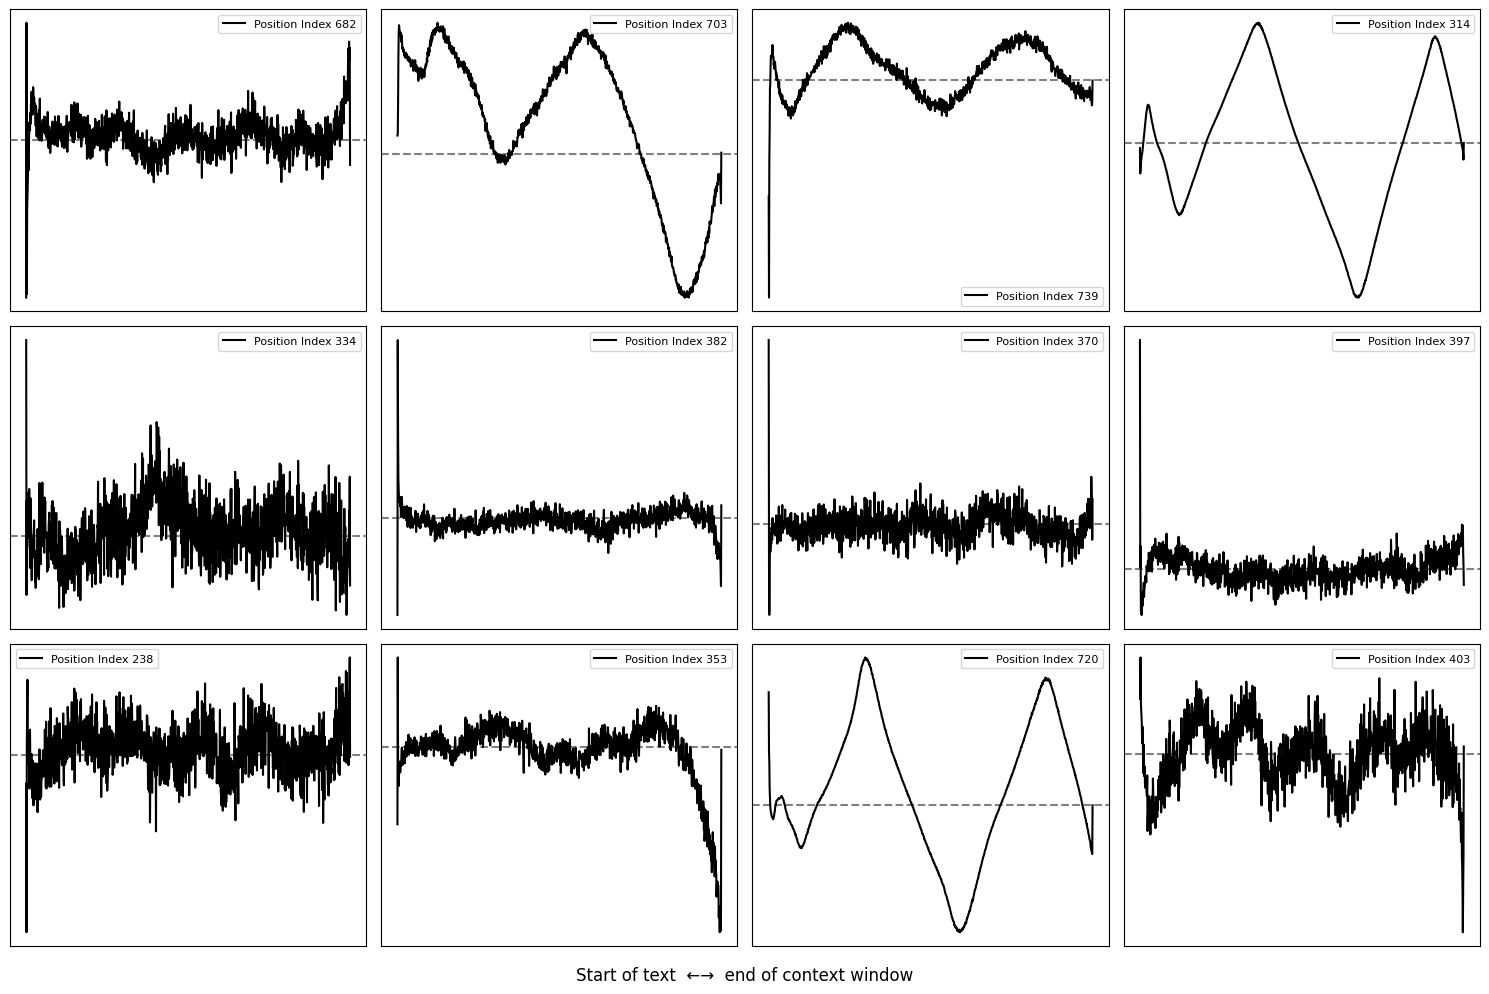

In [5]:
num_positions = pe.shape[1]

fig, axs = plt.subplots(3, 4, figsize=(15, 10))
axs = axs.flatten()

for ax in axs:
    # pick a random position index
    pos_idx = np.random.randint(num_positions)

    # this is a 1D vector of length d_model
    vec = pe[:,pos_idx]

    ax.plot(vec, 'k', label=f'Position Index {pos_idx}')
    # ax.set_title(f'Position Embedding Vector {pos_idx}')
    ax.axhline(0, linestyle='--', color='gray', zorder=-3)
    ax.set(xticks=[], yticks=[])
    ax.legend(fontsize=8)

# put global x-label on the whole figure instead of only the last ax
fig.supxlabel('Start of text  ←→  end of context window', fontsize=12)

plt.tight_layout()
plt.show()

# Similarities across vectors

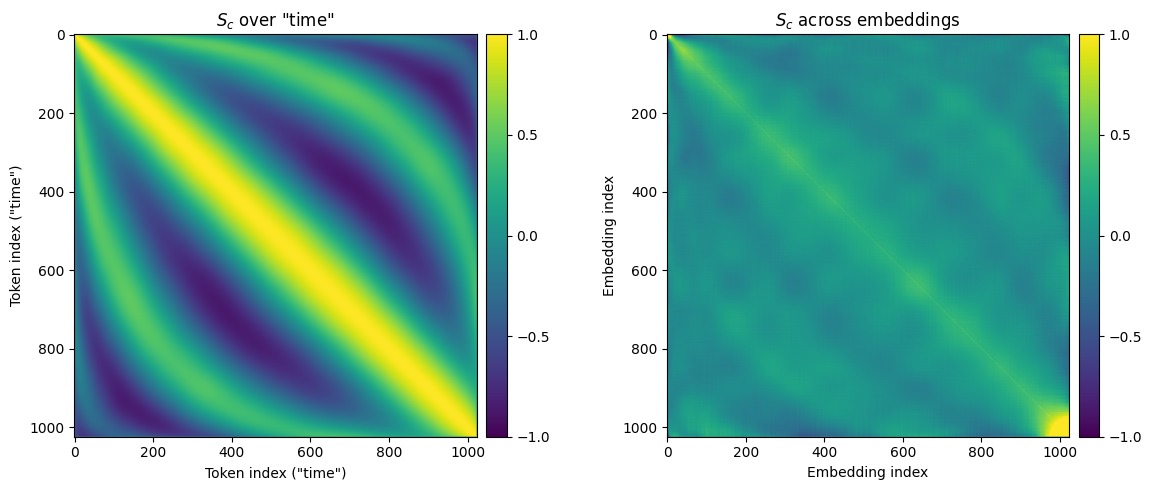

In [6]:
# cosine similarities for "time series" (token index)
Pnorm1 = pe / np.linalg.norm(pe, axis=1, keepdims=True)
cossim_tokens = Pnorm1 @ Pnorm1.T

# cosine similarities across embediing dimensions
Pnorm0 = pe / np.linalg.norm(pe, axis=0, keepdims=True)
cossim_embeds = Pnorm0 @ Pnorm0.T

# draw the images
fig,axs = plt.subplots(1,2,figsize=(12,5))

h = axs[0].imshow(cossim_tokens,vmin=-1,vmax=1)
axs[0].set(xlabel='Token index ("time")',ylabel='Token index ("time")',title='$S_c$ over "time"')
ch = fig.colorbar(h,ax=axs[0],pad=.02,fraction=.046)
ch.ax.tick_params(labelsize=10)
ch.ax.set_yticks(np.arange(-1,1.1,.5))

h = axs[1].imshow(cossim_embeds,vmin=-1,vmax=1)
axs[1].set(xlabel='Embedding index',ylabel='Embedding index',title='$S_c$ across embeddings')
ch = fig.colorbar(h,ax=axs[1],pad=.02,fraction=.046)
ch.ax.tick_params(labelsize=10)
ch.ax.set_yticks(np.arange(-1,1.1,.5))

plt.tight_layout()
plt.show()

# Sinusoidal embeddings as defined in "Attention" paper

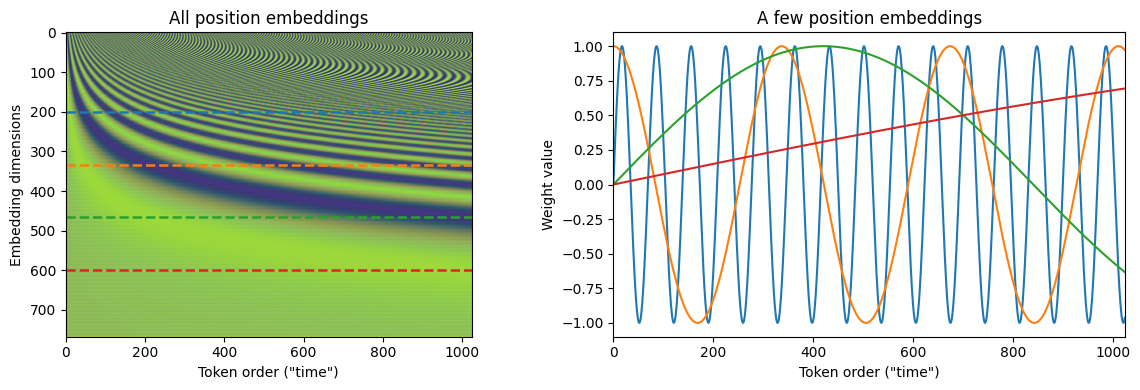

In [7]:
positionsFormula = np.zeros_like(gpt2.wpe.weight.data)
d = positionsFormula.shape[1]

# token position ("time")
th = np.arange(positionsFormula.shape[0])

# create the vectors
for i in range(0,positionsFormula.shape[1],2):

  # denominator scaling factor
  denom = 10000 ** (2*i//2 / d)

  # define the embeddings
  positionsFormula[:,i]   = np.sin(th / denom)
  positionsFormula[:,i+1] = np.cos(th / denom)



#### and visualize
_,axs = plt.subplots(1,2,figsize=(12,4))
axs[0].imshow(positionsFormula.T,vmin=-1,vmax=1)
axs[0].set(ylabel='Embedding dimensions',xlabel='Token order ("time")',title='All position embeddings')

pos2show = np.linspace(200,600,4,dtype=int)
h = axs[1].plot(positionsFormula[:,pos2show])
axs[1].set(ylabel='Weight value',xlabel='Token order ("time")',xlim=[0,len(th)],title='A few position embeddings')

for i,p in enumerate(pos2show):
  axs[0].axhline(p,linestyle='--',color=h[i].get_color(),linewidth=1.8)


plt.tight_layout()
plt.show()

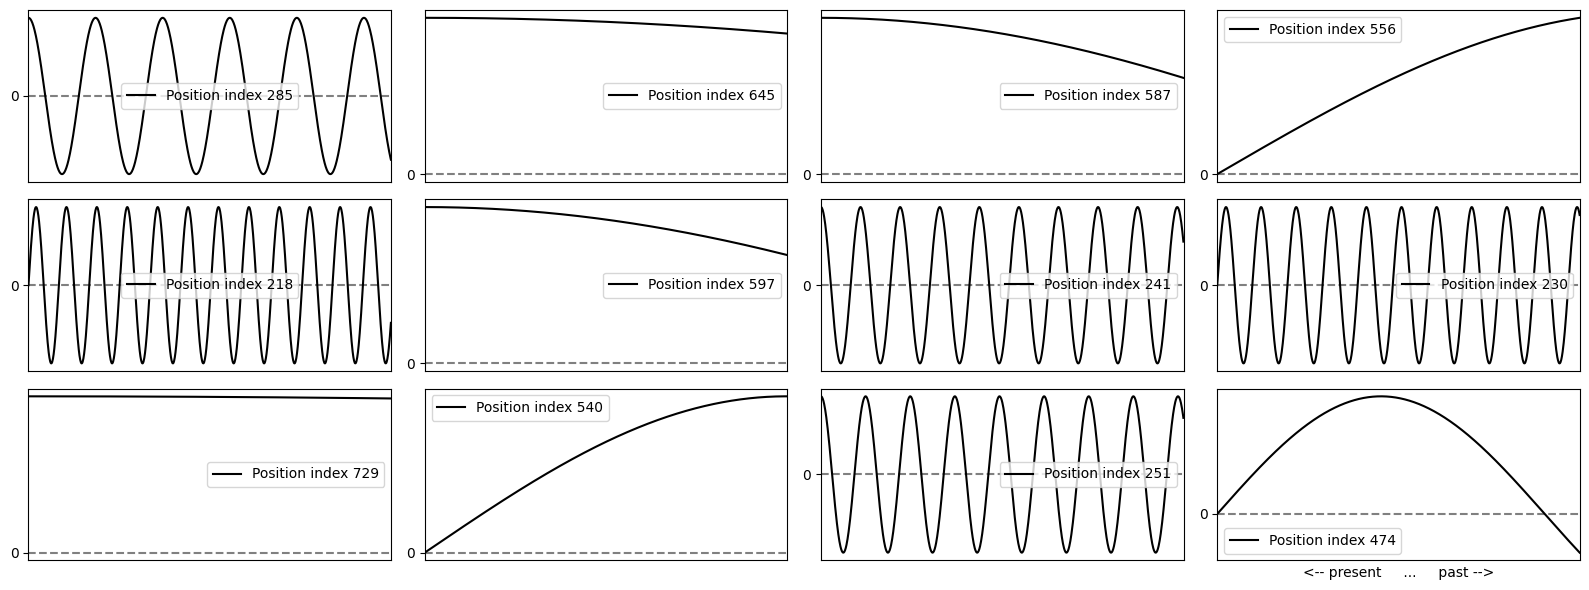

In [8]:
# sample plot as earlier with the learned embeddings

_,axs = plt.subplots(3,4,figsize=(16,6))

# pick random vectors
for a in axs.flatten():

  # a random position embedding vector
  randidx = np.random.randint(pe.shape[1])

  # and plot it
  a.plot(positionsFormula[:,randidx],'k',label=f'Position index {randidx}')
  a.axhline(0,linestyle='--',color='gray',zorder=-3)

  a.set(xticks=[],yticks=[0],xlim=[0,pe.shape[0]])
  a.legend(fontsize=10)


# x-axis label on one plot
a.set(xlabel='<-- present     ...     past -->')
plt.tight_layout()
plt.show()

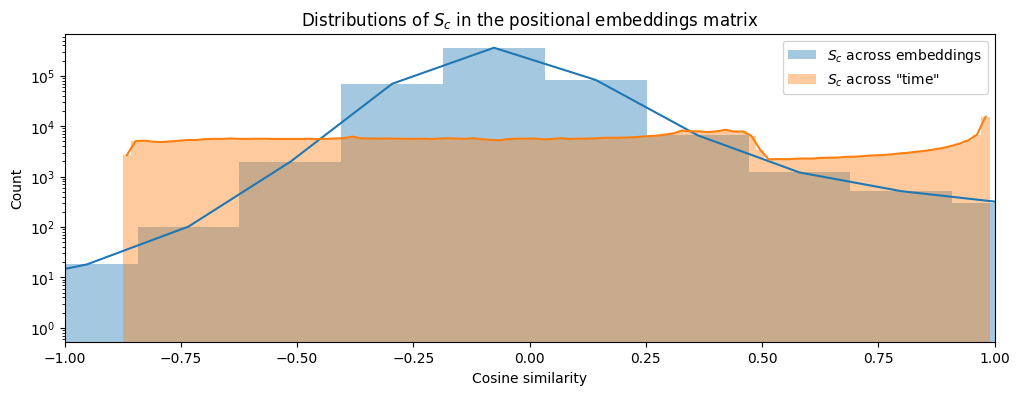

In [9]:
# get the unique cosine similarity values from the upper-triangle
unique_cs_embeds = cossim_embeds[np.nonzero(np.triu(cossim_embeds,1))] # note the ",1" to avoid the trivial diagonal
unique_cs_tokens = cossim_tokens[np.nonzero(np.triu(cossim_tokens,1))]

# get their distributions
embed_hy,embed_hx = np.histogram(unique_cs_embeds,100)
token_hy,token_hx = np.histogram(unique_cs_tokens,100)

# visualize!
plt.figure(figsize=(12,4))
plt.bar(embed_hx[:-1],embed_hy,width=np.diff(embed_hx[:2]),alpha=.4,label='$S_c$ across embeddings')
plt.bar(token_hx[:-1],token_hy,width=np.diff(token_hx[:2]),alpha=.4,label='$S_c$ across "time"')
plt.plot(embed_hx[:-1],embed_hy)
plt.plot(token_hx[:-1],token_hy)

plt.legend()
plt.gca().set(xlim=[-1,1],xlabel='Cosine similarity',ylabel='Count',title='Distributions of $S_c$ in the positional embeddings matrix',yscale='log')
plt.show()

# Create and visualize a shuffled cosine similarity of positional embeddings

In [10]:
# Vectorize and copy the positions
random_pe = pe.flatten()

# Random shuffle the vector
np.random.shuffle(random_pe)

# Reshape the vector
random_pe = random_pe.reshape(pe.shape)

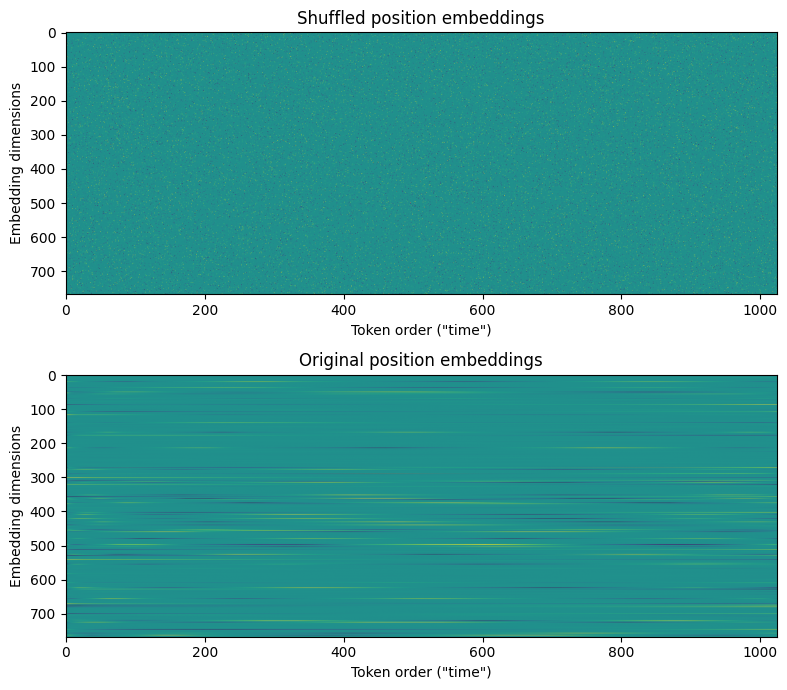

In [15]:
# Plot the shuffled embeddings
_, axs = plt.subplots(2, 1, figsize=(8, 7))

axs[0].imshow(random_pe.T, aspect='auto',vmin=-1, vmax=1)
axs[0].set(xlabel='Token order ("time")', ylabel='Embedding dimensions', title='Shuffled position embeddings')

axs[1].imshow(pe.T, aspect='auto',vmin=-1, vmax=1)
axs[1].set(xlabel='Token order ("time")', ylabel='Embedding dimensions', title='Original position embeddings')

plt.tight_layout()
plt.show()
# Plot

# Plot the cosine pair-wise similarities for each Positional Embeddings Matrix

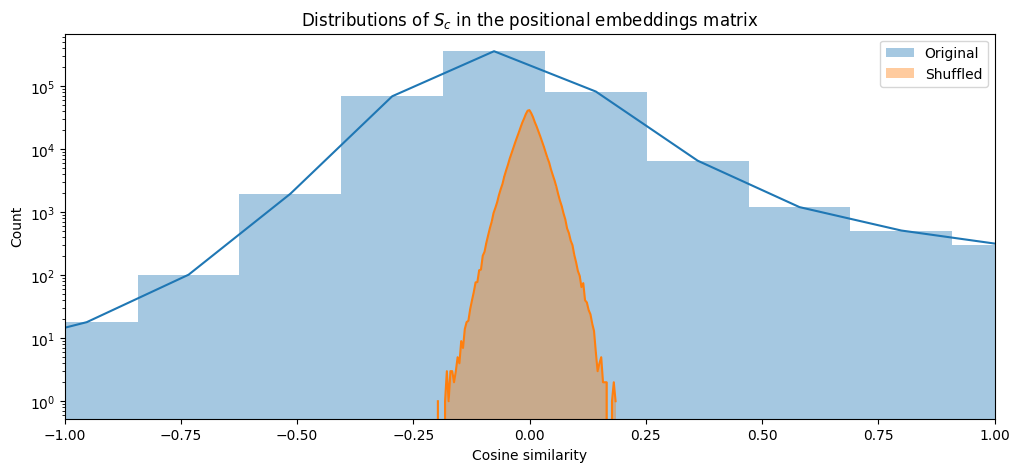

In [17]:
# Calculate the cosine similarity for the shuffled matrix
Rnorm0 = random_pe / np.linalg.norm(random_pe, axis=0, keepdims=True)
cossim_embeds_shuffled = Rnorm0 @ Rnorm0.T

# Calculate the cosine similarity for the original
Pnorm0 = pe / np.linalg.norm(pe, axis=0, keepdims=True)
cossim_embeds_original = Pnorm0 @ Pnorm0.T

# Get the unique cosine similarities of both
unique_cs_shuffled = cossim_embeds_shuffled[np.nonzero(np.triu(cossim_embeds_shuffled, 1))]
unique_cs_original = cossim_embeds_original[np.nonzero(np.triu(cossim_embeds_original, 1))]

# Get their frequency distribution
randidx_hy, randidx_hx = np.histogram(unique_cs_shuffled, 100)
origidx_hy, origidx_hx = np.histogram(unique_cs_original, 100)

# Plot the cosine similarity
fig = plt.subplots(figsize=(12, 5))
plt.bar(origidx_hx[:-1], origidx_hy, width=np.diff(origidx_hx[:2]), alpha=.4, label='Original')
plt.bar(randidx_hx[:-1], randidx_hy, width=np.diff(randidx_hx[:2]), alpha=.4, label='Shuffled')
plt.plot(origidx_hx[:-1], origidx_hy)
plt.plot(randidx_hx[:-1], randidx_hy)

plt.legend()
plt.gca().set(xlim=[-1, 1], xlabel='Cosine similarity', ylabel='Count',
               title='Distributions of $S_c$ in the positional embeddings matrix', yscale='log')
plt.show()
